# Merchant Ranking Algorith
The method of ranking each merchant, will take inspiration from the methods proposed in (https://sapinsider.org/leveraging-analytical-method-for-ranking-suppliers/), in which we rank each key attribute out of 5, then sum them together with weightsget a score for each merchant. 

The Key Attributes for now are: 
- Revenue
- Customer_Base 
- Sustainability
- Envirnment

In [1]:
from pyspark.sql import SparkSession, functions as F
from pyspark.ml import feature as H
# First lets reed the datasets
spark = (
    SparkSession.builder.appName("Data_Explorer")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/10/09 12:29:36 WARN Utils: Your hostname, James-N580VD-DM229T resolves to a loopback address: 127.0.1.1; using 172.27.209.140 instead (on interface eth0)
22/10/09 12:29:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/09 12:29:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Read the datasets 
transactions = spark.read.parquet('../data/processed/transactions')
merchants =  spark.read.parquet('../data/processed/merchants/')
#full_dataset = spark.read.parquet('../data/curated/full_dataset/')
final_data_collection = merchants.select('merchant_abn')

In [8]:
spark.read.parquet('../data/curated/')

user_id,merchant_abn,dollar_value,order_datetime,order_id
14935,79417999332,136.07,2021-11-26,68719476736
1,46451548968,72.62,2021-11-26,68719476737
14936,89518629617,3.08,2021-11-26,68719476738
1,49167531725,51.58,2021-11-26,68719476739
14936,31101120643,25.23,2021-11-26,68719476740
2,67978471888,691.5,2021-11-26,68719476741
14936,60956456424,102.14,2021-11-26,68719476742
2,47644196714,644.52,2021-11-26,68719476743
14938,39649557865,209.13,2021-11-26,68719476744
3,88402174457,141.04,2021-11-26,68719476745


In [3]:
# Define our scaliong function
def feature_standardisation(colums, dataset): 
    for col_name in colums:
        values = dataset.select(F.max(col_name).alias('high'), F.min(col_name).alias('low'))
        dataset = dataset.withColumn(col_name, F.round((F.col(col_name) - values.select('low').head()[0]) / (values.select('high').head()[0] - values.select('low').head()[0]), 4))
        return dataset

# Concerns
Just stuff i came across whilst implementing

<AxesSubplot:xlabel='dollar_value', ylabel='Count'>

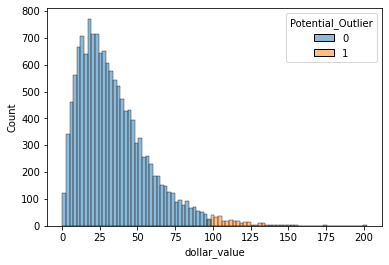

In [4]:
# Case: if we use a cut-off point for the fraud probability, and minus the dollar_value of 'fraud' transactions
concern1 = transactions.where(F.col('merchant_abn') == 83412691377).select('Potential_Outlier', 'dollar_value').toPandas()
import seaborn as sns
sns.histplot(x='dollar_value', hue='Potential_Outlier', data=concern1)
# From counting the total revenue for each merchant using such method, I found that some have negative ones (but just using outlier_attr).
# However, due to most outluiers being larger than the mean, minusing it results in devestating loss to revenue, which is to consider

# 1. Tansaction_Revenue
For this we will look into:
- Renevue (Recent)
- Projected Revenue 

In [5]:
# For revenue, we first set the break point as what we determine as 'Recent'
# We will for now determine as last 6 months (i.e march) 
RECENCY =  F.lit('2022-03-01')

In [6]:
transactions.limit(10)

order_id,user_id,merchant_abn,dollar_value,order_datetime,Natural_var,Potential_Outlier,holiday,dayofmonth,month,dayofweek
3,3,60956456424,136.68,2021-08-20,0,0,0,20,8,6
8,18482,70501974849,68.75,2021-08-20,0,0,0,20,8,6
11,7,33064796871,373.09,2021-08-20,0,0,0,20,8,6
12,18483,44160392990,83.98,2021-08-20,0,0,0,20,8,6
35,20,67202032418,55.46,2021-08-20,0,0,0,20,8,6
37,20,71787414647,88.18,2021-08-20,0,0,0,20,8,6
49,25,32234779638,87.16,2021-08-20,0,0,0,20,8,6
55,28,77679081913,23.22,2021-08-20,0,0,0,20,8,6
61,34,28341499489,216.94,2021-08-20,0,0,0,20,8,6
62,18509,12173100693,81.33,2021-08-20,0,0,0,20,8,6


1.1 Revenue

In [18]:
# take subset
revenue_data = transactions.where(F.col('order_datetime') > RECENCY).select('merchant_abn', 'dollar_value', 'BNPL_Revenue', 'Potential_Outlier')

In [ ]:
# Proper method (with the probabilities)
# revenue_data = revenue_data.withColumn('BNPL_weighted_Revenue', F.col('BNPL_Revenue') * F.col('Fraud_probability'))

In [19]:
# Alternative Method
revenue_data = revenue_data.withColumn('BNPL_weighted_Revenue', F.when(F.col('Potential_Outlier') == False, F.col('BNPL_Revenue'))
                                                                 .otherwise(-1 * F.col('dollar_value'))
                                                                 )

In [20]:
# Now can caluculate each Merchants revenue
revenue_data = revenue_data.groupBy('merchant_abn').agg(F.round(F.sum('BNPL_weighted_Revenue'), 2).alias('Total_Revenue'))

In [27]:
# Standardise
revenue_data = feature_standardisation(['Total_Revenue'],revenue_data)

1.2 Projections (Need to add)

# Sustainability 
Next, we add a rating for a companies growth/longevity

In [68]:
merchants_sub = merchants.select(['merchant_abn', 'avg_monthly_inc', 'postcode_entropy'])

In [10]:
for col_name in merchants_sub.columns[1:]:
    values = merchants_sub.select(F.max(col_name).alias('high'), F.min(col_name).alias('low'))
    merchants_sub = merchants_sub.withColumn(col_name, (F.col(col_name) - values.select('low').head()[0]) / (values.select('high').head()[0] - values.select('low').head()[0]))

In [11]:
merchants_sub = merchants_sub.withColumn('Sustainability_score', F.col('avg_monthly_inc') - F.col('postcode_entropy'))

In [12]:
merchants_sub = merchants_sub.select(['merchant_abn', 'Sustainability_score'])
final_data_collection = final_data_collection.join(merchants_sub, on=['merchant_abn'])

# Customer Base
In this sections we use the features:
- customer_loyalty_agg
- unique_cust
- Total_Customers*
- Cust_tax (TBC)

1.1 Loyalty

In [61]:
# Create Loyalfy feature
grouped = full_dataset.groupBy("user_id", "merchant_abn")
RPR = grouped.count().withColumnRenamed("count", "RPR")
upSell = RPR.groupBy("user_id").count().withColumnRenamed("count", "upsell")
CLV = grouped.sum("dollar_value").withColumnRenamed("sum(dollar_value)", "CLV")
# Define the window
from pyspark.sql.window import Window
w = Window.partitionBy(["user_id", "merchant_abn"]).orderBy("order_datetime")

retention = full_dataset.withColumn(
    'diff',
    F.datediff(F.col("order_datetime"), F.lag("order_datetime").over(w))
).groupBy("user_id", "merchant_abn").agg(F.avg(F.col("diff")).alias("retention"))
retention.agg({"retention":"max"}).collect()
retention.na.fill(value=365)
loyal = retention.na.fill(value=365).join(RPR, on=["user_id", "merchant_abn"], how="left").join(CLV, on=["user_id", "merchant_abn"], how="left").join(upSell, on=["user_id"], how="left")
loyal = loyal.withColumn("loyal", F.col("RPR") * F.col("CLV") * F.col("upSell") / F.col("retention"))

In [74]:
from pyspark.sql.functions import col
from pyspark.sql import Window
loyal = loyal.select(*(col(c).cast("float").alias(c) for c in loyal.columns))
loyal = loyal.select('user_id', 'merchant_abn', 'loyal')

In [75]:
grp_window = Window.partitionBy('grp')
magic_percentile = F.expr('percentile_approx(loyal, 0.5)')
loyal = loyal.join(loyal.groupBy('user_id').agg(magic_percentile.alias('med_val')), on='user_id', how='left')

In [76]:
from pyspark.sql.functions import coalesce
loyal = loyal.withColumn('loyal', coalesce('loyal', 'med_val')).select(['user_id', 'merchant_abn', 'loyal'])
loyal_agg = loyal.groupBy('merchant_abn').avg('loyal').alias('Loyal_AVG')

Add few other metrics (Need to still add Postcode Entropy...)

In [77]:
cust_data =  full_dataset.groupBy('merchant_abn').agg(F.countDistinct('user_id').alias('Unique_Customers'), F.round(F.count('user_id') / F.countDistinct('user_id'), 2).alias('Transaction_per_User'), F.round(F.avg('Average taxable income or loss'),2).alias('customer_wealth'))
cust_data = cust_data.join(loyal_agg, on='merchant_abn')

In [78]:
cust_data = feature_standardisation(['Transaction_per_User', 'customer_wealth', 'Unique_Customers', 'Loyal_AVG'], cust_data)